<a href="https://colab.research.google.com/github/koleshjr/AI4D-LAB-HACKATHON-CHALLENGE/blob/main/Winning_solution_everything.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tanzania Tourism EDA

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import necessary Libraries and load the data

In [ ]:
#Import some libraries
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import plotly.express as px
from pylab import rcParams
import seaborn as sb
sb.set_style('darkgrid')
rcParams['figure.figsize'] = 8,8
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

import catboost as catt

from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold,StratifiedGroupKFold,KFold,RepeatedStratifiedKFold,train_test_split

pd.options.display.max_rows = 2200

In [ ]:
path = "/content/drive/MyDrive/Tourism_wINNER/"

In [ ]:
#import data
train = pd.read_csv(path+'Train.csv')
test=  pd.read_csv(path+'Test.csv')
submission = pd.read_csv(path+'SampleSubmission.csv')


In [ ]:
train.shape,test.shape

((18506, 21), (6169, 20))

In [ ]:
train.head()

,Tour_ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,first_trip_tz,cost_category
0,tour_id1hffseyw,ITALY,45-64,With Children,0.0,2.0,Visiting Friends and Relatives,Beach Tourism,"Friends, relatives",Package Tour,...,Yes,Yes,Yes,No,No,No,0,7,Yes,High Cost
1,tour_idnacd7zag,UNITED KINGDOM,25-44,With Spouse,1.0,1.0,Leisure and Holidays,Wildlife Tourism,"Travel agent, tour operator",Package Tour,...,Yes,Yes,Yes,No,No,No,0,7,Yes,High Cost
2,tour_id62vz7e71,UNITED STATES OF AMERICA,65+,With Spouse,1.0,1.0,Leisure and Holidays,Widlife Tourism,"Travel agent, tour operator",Package Tour,...,Yes,Yes,Yes,Yes,Yes,No,6,6,Yes,Higher Cost
3,tour_idrc76tzix,RWANDA,25-44,With Spouse and Children,3.0,1.0,Leisure and Holidays,Beach Tourism,"Radio, TV, Web",Independent,...,No,No,No,No,No,No,3,0,No,Lower Cost
4,tour_idn723m0n9,UNITED STATES OF AMERICA,45-64,Alone,0.0,1.0,Leisure and Holidays,Widlife Tourism,"Travel agent, tour operator",Package Tour,...,Yes,Yes,Yes,No,Yes,Yes,7,0,Yes,Higher Cost


### DATA STATISTICAL INFORMATION

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18506 entries, 0 to 18505
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Tour_ID                18506 non-null  object 
 1   country                18506 non-null  object 
 2   age_group              18506 non-null  object 
 3   travel_with            17431 non-null  object 
 4   total_female           18504 non-null  float64
 5   total_male             18500 non-null  float64
 6   purpose                18506 non-null  object 
 7   main_activity          18506 non-null  object 
 8   info_source            18506 non-null  object 
 9   tour_arrangement       18506 non-null  object 
 10  package_transport_int  18506 non-null  object 
 11  package_accomodation   18506 non-null  object 
 12  package_food           18506 non-null  object 
 13  package_transport_tz   18506 non-null  object 
 14  package_sightseeing    18506 non-null  object 
 15  pa

#### We can see a mixture of object columns and int ones with object columns being the majority ones

In [ ]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
total_female,18504.0,0.936230,1.215582,0.0,0.0,1.0,1.0,49.0
total_male,18500.0,0.998757,1.173177,0.0,1.0,1.0,1.0,58.0
night_mainland,18506.0,9.141576,14.127449,0.0,3.0,6.0,11.0,365.0
night_zanzibar,18506.0,2.493516,5.275156,0.0,0.0,0.0,4.0,240.0


#### The max is so far away from the 75th percentile in almost all cols, Are those outliers??  we will see

## Missing values

In [ ]:
#check for missing values
percent_missing = train.isnull().sum() * 100 / len(train)
missing_value_train = pd.DataFrame({'column_name': train.columns,
                                 'percent_missing': percent_missing})
missing_value_train

,column_name,percent_missing
Tour_ID,Tour_ID,0.000000
country,country,0.000000
age_group,age_group,0.000000
travel_with,travel_with,5.808927
total_female,total_female,0.010807
total_male,total_male,0.032422
purpose,purpose,0.000000
main_activity,main_activity,0.000000
info_source,info_source,0.000000
tour_arrangement,tour_arrangement,0.000000


#### Only few columns with missing values which are travel_with with 5%, total_female 0.01%, total_male 0.03%. There are many ways to feeel this columns, You've to try all and evaluate which is best

In [ ]:
train.isnull().sum()

Tour_ID                     0
country                     0
age_group                   0
travel_with              1075
total_female                2
total_male                  6
purpose                     0
main_activity               0
info_source                 0
tour_arrangement            0
package_transport_int       0
package_accomodation        0
package_food                0
package_transport_tz        0
package_sightseeing         0
package_guided_tour         0
package_insurance           0
night_mainland              0
night_zanzibar              0
first_trip_tz               0
cost_category               0
dtype: int64

In [ ]:
cat_columns = [col for col in train.select_dtypes('object').columns]

num_columns = [col for col in train.select_dtypes(['int', 'float']).columns]

### Lets fill the categorical ones with A new column

In [ ]:
for col in train.columns:

  if col in cat_columns:
    fillna_const = 'MISSING_VALUE'
    train[col] = train[col].astype('str').fillna(fillna_const)
    

# Confirm that there aren't any missing values
train[train.columns.difference(['cost_category'])].isna().sum()

Tour_ID                  0
age_group                0
country                  0
first_trip_tz            0
info_source              0
main_activity            0
night_mainland           0
night_zanzibar           0
package_accomodation     0
package_food             0
package_guided_tour      0
package_insurance        0
package_sightseeing      0
package_transport_int    0
package_transport_tz     0
purpose                  0
total_female             2
total_male               6
tour_arrangement         0
travel_with              0
dtype: int64

In [ ]:
for col in test.columns:

  if col in cat_columns:
    fillna_const = 'MISSING_VALUE'
    test[col] = test[col].astype('str').fillna(fillna_const)
    

# Confirm that there aren't any missing values
test[test.columns.difference(['total_cost'])].isna().sum()

Tour_ID                  0
age_group                0
country                  0
first_trip_tz            0
info_source              0
main_activity            0
night_mainland           0
night_zanzibar           0
package_accomodation     0
package_food             0
package_guided_tour      0
package_insurance        0
package_sightseeing      0
package_transport_int    0
package_transport_tz     0
purpose                  0
total_female             2
total_male               1
tour_arrangement         0
travel_with              0
dtype: int64

### Lets handle the numerical columns by filling with 0

In [ ]:
for col in train.columns:

  if col in num_columns:
    train[col] = train[col].fillna(0)

# Confirm that there aren't any missing values
train[train.columns.difference(['cost_category'])].isna().sum()

Tour_ID                  0
age_group                0
country                  0
first_trip_tz            0
info_source              0
main_activity            0
night_mainland           0
night_zanzibar           0
package_accomodation     0
package_food             0
package_guided_tour      0
package_insurance        0
package_sightseeing      0
package_transport_int    0
package_transport_tz     0
purpose                  0
total_female             0
total_male               0
tour_arrangement         0
travel_with              0
dtype: int64

In [ ]:
for col in test.columns:

  if col in num_columns:
    test[col] = test[col].fillna(0)

# Confirm that there aren't any missing values
test[test.columns.difference(['cost_category'])].isna().sum()

Tour_ID                  0
age_group                0
country                  0
first_trip_tz            0
info_source              0
main_activity            0
night_mainland           0
night_zanzibar           0
package_accomodation     0
package_food             0
package_guided_tour      0
package_insurance        0
package_sightseeing      0
package_transport_int    0
package_transport_tz     0
purpose                  0
total_female             0
total_male               0
tour_arrangement         0
travel_with              0
dtype: int64

## Categorical Data

In [ ]:
# check unique values in dataset
train.apply(lambda x: len(x.unique()))

Tour_ID                  18506
country                    131
age_group                    5
travel_with                  6
total_female                24
total_male                  24
purpose                      8
main_activity               10
info_source                  8
tour_arrangement             2
package_transport_int        2
package_accomodation         2
package_food                 2
package_transport_tz         2
package_sightseeing          2
package_guided_tour          2
package_insurance            2
night_mainland             110
night_zanzibar              60
first_trip_tz                2
cost_category                6
dtype: int64

## Levels In the Categorical Data with a lot of classes
* Country - 106 , we have to ensure that some of these are also on test, if not our a cv should consider this
* There are also numerical columns with levels so lets look at them( total_male,total_female,night_mainland,night_zanzibar


### Country

In [ ]:
train['country'].value_counts()

UNITED STATES OF AMERICA    2846
UNITED KINGDOM              2120
ITALY                       1625
FRANCE                      1064
GERMANY                      969
SOUTH AFRICA                 811
KENYA                        781
ZAMBIA                       715
AUSTRALIA                    704
CANADA                       571
ZIMBABWE                     570
UGANDA                       527
SPAIN                        470
INDIA                        408
NETHERLANDS                  381
SWIZERLAND                   278
BELGIUM                      244
SWEDEN                       235
BURUNDI                      231
CHINA                        216
UAE                          187
DENMARK                      178
NORWAY                       151
RWANDA                       145
JAPAN                        137
AUSTRIA                      124
IRELAND                      122
OMAN                          92
POLAND                        84
DRC                           82
NEW ZEALAN

In [ ]:
test['country'].value_counts()

UNITED STATES OF AMERICA    919
UNITED KINGDOM              699
ITALY                       546
FRANCE                      346
GERMANY                     342
KENYA                       259
SOUTH AFRICA                251
ZAMBIA                      239
AUSTRALIA                   235
CANADA                      224
ZIMBABWE                    209
SPAIN                       173
UGANDA                      167
INDIA                       128
NETHERLANDS                 112
SWIZERLAND                  100
SWEDEN                       86
BURUNDI                      83
CHINA                        78
BELGIUM                      71
DENMARK                      60
UAE                          60
JAPAN                        51
NORWAY                       47
RWANDA                       47
IRELAND                      44
DRC                          39
AUSTRIA                      35
OMAN                         30
POLAND                       28
KOREA                        26
NEW ZEAL

#### Looks like most of them are in train so not a problem,but we can cluster them to those in africa and those outside africa and moree levels if you want so we are going to do that later when we combine both datasets

### Total Male and Total Female

1.0     11808
0.0      4340
2.0      1501
3.0       510
4.0       149
5.0        67
6.0        55
7.0        23
8.0        12
9.0         9
10.0        9
13.0        4
11.0        3
12.0        3
15.0        3
17.0        2
24.0        1
14.0        1
58.0        1
44.0        1
40.0        1
23.0        1
20.0        1
25.0        1
Name: total_male, dtype: int64


Text(0.5, 0, 'total_male')

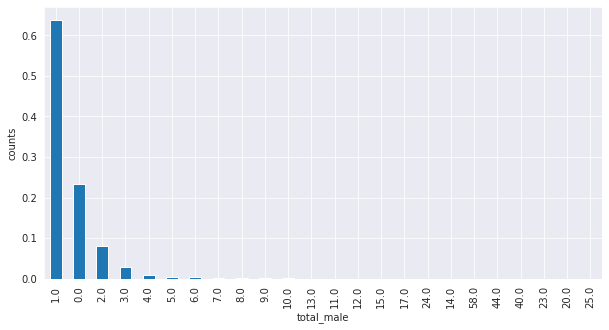

In [ ]:
print(train['total_male'].value_counts())
plt.figure(figsize=(10,5))
train['total_male'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('total_male')

1.0     9659
0.0     6149
2.0     1752
3.0      507
4.0      196
5.0       89
6.0       60
7.0       18
8.0       17
10.0      13
11.0       9
12.0       8
9.0        8
14.0       6
13.0       3
15.0       3
24.0       2
49.0       1
20.0       1
17.0       1
22.0       1
26.0       1
19.0       1
23.0       1
Name: total_female, dtype: int64


Text(0.5, 0, 'total_female')

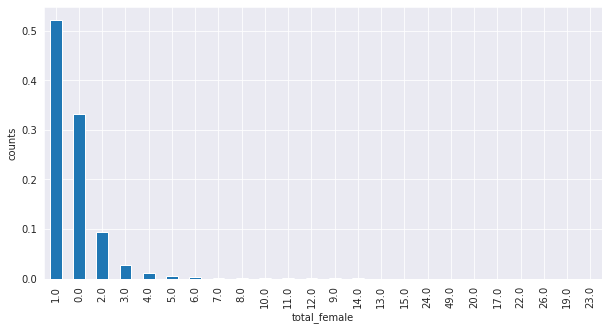

In [ ]:
print(train['total_female'].value_counts())
plt.figure(figsize=(10,5))
train['total_female'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('total_female')

### Night Mainland and Night Zanzibar

0      2344
7      1678
4      1337
2      1294
3      1291
6      1268
5      1258
10     1102
8       779
9       733
14      708
12      640
1       637
11      524
15      397
13      367
30      219
16      215
20      211
21      173
17      150
60       85
18       78
19       71
90       59
25       57
23       52
22       51
28       48
24       46
42       40
26       38
27       38
35       36
40       33
29       33
45       32
50       23
32       21
33       20
31       18
70       17
34       16
36       14
39       13
48       13
56       13
37       12
43       12
63       10
55       10
54       10
49        9
80        8
44        8
47        8
46        7
68        6
38        6
62        6
150       5
180       5
65        4
120       4
53        4
75        4
58        4
61        4
41        4
57        3
85        3
69        3
86        3
66        3
88        3
59        3
64        3
365       2
51        2
87        2
100       2
364       2
288       2
77  

Text(0.5, 0, 'night_mainland')

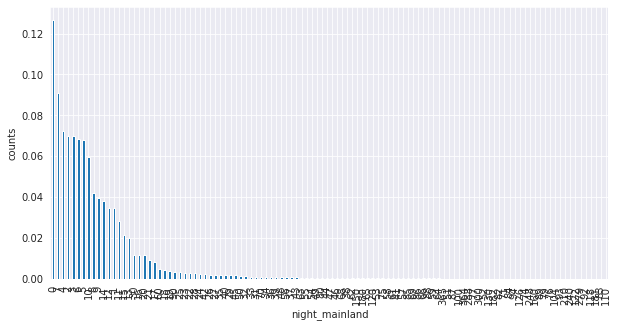

In [ ]:
print(train['night_mainland'].value_counts())
plt.figure(figsize=(10,5))
train['night_mainland'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('night_mainland')

0      11579
7       1533
4       1030
3        921
5        813
6        624
2        426
8        284
10       244
14       216
9        171
1        152
12        87
11        78
15        64
13        62
20        33
21        26
17        24
16        19
19        13
30        13
18         9
22         8
28         8
35         6
23         6
60         6
27         4
25         4
90         4
41         3
33         3
40         2
42         2
51         2
120        2
39         2
44         2
45         1
31         1
32         1
46         1
240        1
43         1
80         1
87         1
108        1
75         1
64         1
107        1
48         1
50         1
34         1
26         1
70         1
55         1
100        1
61         1
86         1
Name: night_zanzibar, dtype: int64


Text(0.5, 0, 'night_zanzibar')

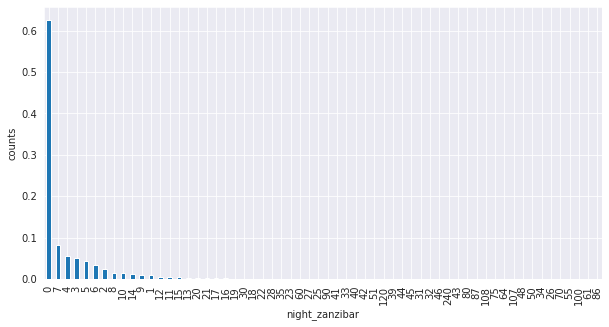

In [ ]:
print(train['night_zanzibar'].value_counts())
plt.figure(figsize=(10,5))
train['night_zanzibar'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('night_zanzibar')

#### For both the total_male and total_female looks like they travel in less than 5people(0,1 being the highest)
#### For both the night zanzibar and night mainland looks majority spend a week there

#### For these feature we can get total people and total nights as new features. Also an interaction of total nights and total people

#### Also cap them since the max is so far away from the 75th percentile

## Levels In the Categorical Data with less number of classes

### Age Group

25-44    9047
45-64    5648
18-24    2222
65+      1467
<18       122
Name: age_group, dtype: int64


Text(0.5, 0, 'age_group')

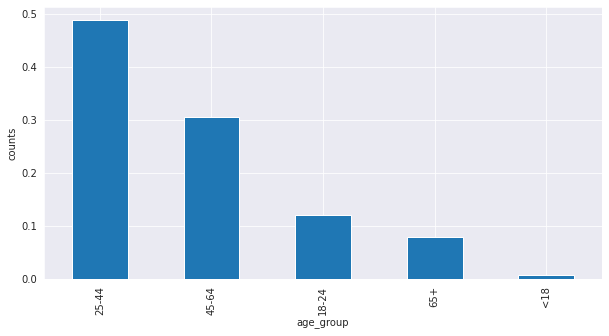

In [ ]:
print(train['age_group'].value_counts())
plt.figure(figsize=(10,5))
train['age_group'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('age_group')

#### 25-44 age group are the majority since they are in the working class and have freedom+ energy.This feature is in contention for a StratifiedGroupKFold as per the description

### Travel With

Alone                           7590
With Spouse                     4842
With Other Friends/Relatives    3268
With Spouse and Children        1193
nan                             1075
With Children                    538
Name: travel_with, dtype: int64


Text(0.5, 0, 'travel_with')

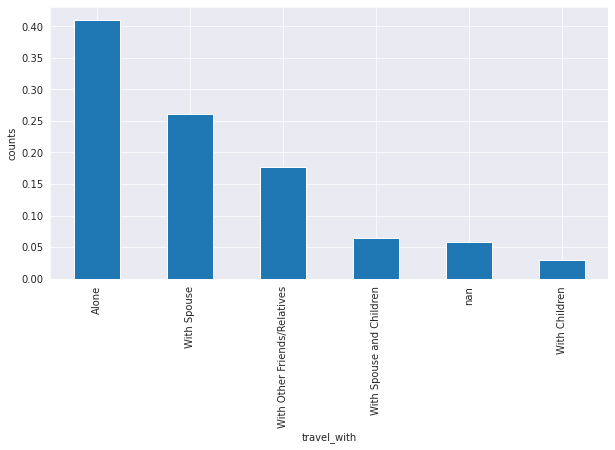

In [ ]:
print(train['travel_with'].value_counts())
plt.figure(figsize=(10,5))
train['travel_with'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('travel_with')

### Purpose

#### Alone the majority, followed by spouse which is understandable

Leisure and Holidays              11755
Visiting Friends and Relatives     2304
Business                           2297
Meetings and Conference            1179
Volunteering                        438
Other                               326
Scientific and Academic             198
Medical                               9
Name: purpose, dtype: int64


Text(0.5, 0, 'purpose')

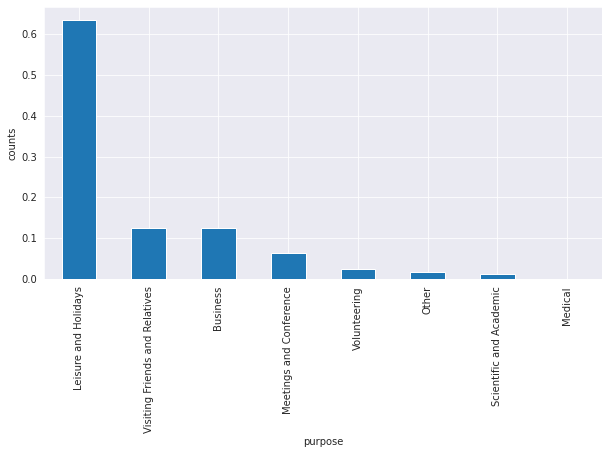

In [ ]:
print(train['purpose'].value_counts())
plt.figure(figsize=(10,5))
train['purpose'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('purpose')

#### Understandable with majority being here for leisure and holiday. This feature is also in contention for a Group KFold as per the description

### Main Activity

Widlife Tourism             5988
Beach Tourism               4172
Wildlife Tourism            2283
Conference Tourism          1920
Hunting Tourism             1712
Cultural Tourism            1444
Mountain Climbing            529
Business                     280
Bird Tourism                 144
Diving and Sport Fishing      34
Name: main_activity, dtype: int64


Text(0.5, 0, 'main_activity')

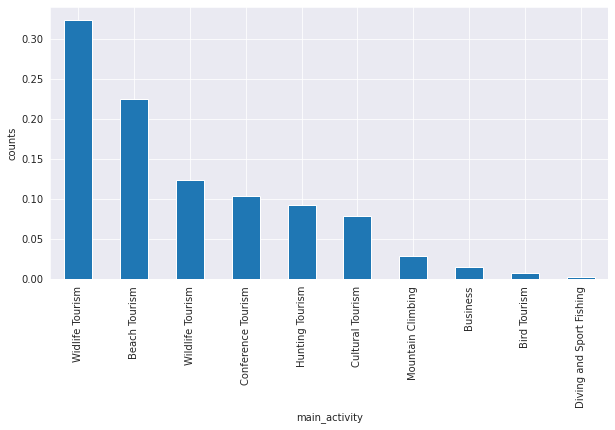

In [ ]:
print(train['main_activity'].value_counts())
plt.figure(figsize=(10,5))
train['main_activity'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('main_activity')

#### Wildlife Tourism is the majority one, since AFrica is well know for Tourism

 ### Info Source

Travel agent, tour operator        8005
Friends, relatives                 6077
Others                             1368
Newspaper, magazines, brochures    1301
Radio, TV, Web                     1223
Trade fair                          243
Tanzania Mission Abroad             197
Inflight magazines                   92
Name: info_source, dtype: int64


Text(0.5, 0, 'info_source')

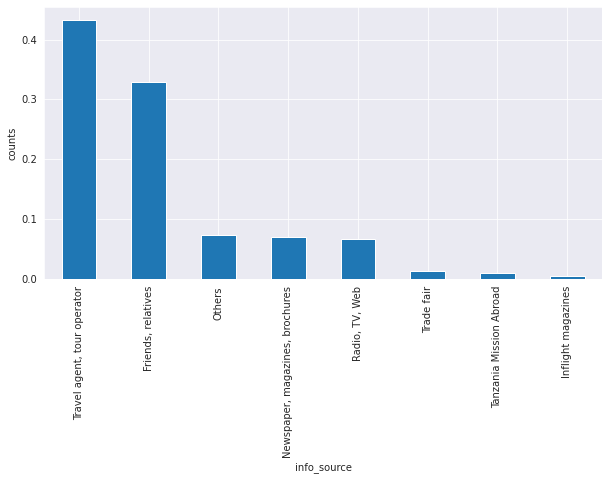

In [ ]:
print(train['info_source'].value_counts())
plt.figure(figsize=(10,5))
train['info_source'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('info_source')

#### Travel agencies are the leading source of info, which is understandable followed by friends 

### Tour Arrangement

Package Tour    9295
Independent     9211
Name: tour_arrangement, dtype: int64


Text(0.5, 0, 'tour_arrangement')

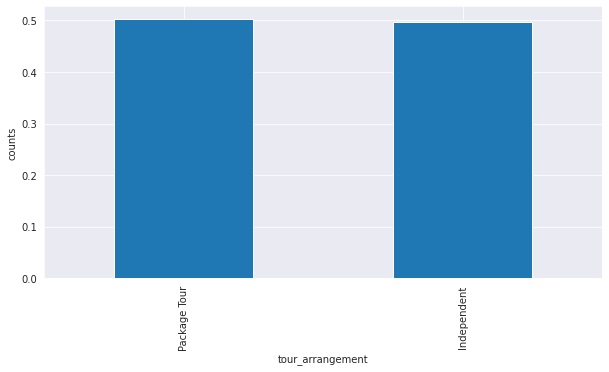

In [ ]:

print(train['tour_arrangement'].value_counts())
plt.figure(figsize=(10,5))
train['tour_arrangement'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('tour_arrangement')

#### Equal distribution here

### Package Transport Int

No     12238
Yes     6268
Name: package_transport_int, dtype: int64


Text(0.5, 0, 'package_transport_int')

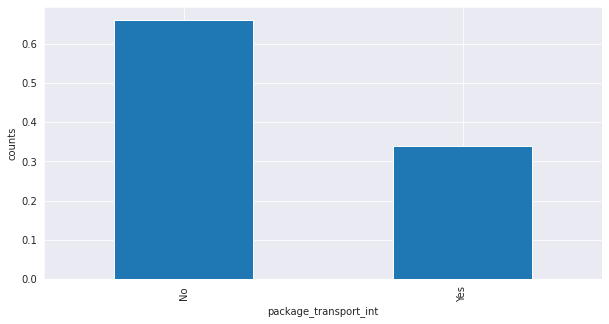

In [ ]:

print(train['package_transport_int'].value_counts())
plt.figure(figsize=(10,5))
train['package_transport_int'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('package_transport_int')

#### Majority the international transport wasn't provided

### Package Accomodation

No     9541
Yes    8965
Name: package_accomodation, dtype: int64


Text(0.5, 0, 'package_accomodation')

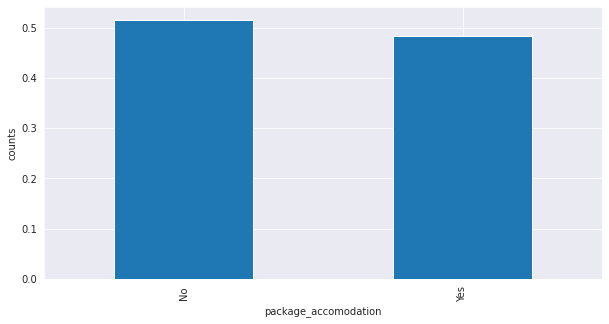

In [ ]:

print(train['package_accomodation'].value_counts())
plt.figure(figsize=(10,5))
train['package_accomodation'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('package_accomodation')

#### Majority The accomodation package was not provided although equal distribution

### Package Food

No     10143
Yes     8363
Name: package_food, dtype: int64


Text(0.5, 0, 'package_food')

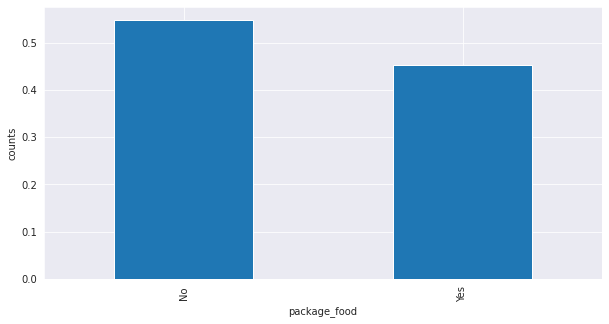

In [ ]:

print(train['package_food'].value_counts())
plt.figure(figsize=(10,5))
train['package_food'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('package_food')

#### Majority Package food wasnt provided

### Package Transport TZ

No     10873
Yes     7633
Name: package_transport_tz, dtype: int64


Text(0.5, 0, 'package_transport_tz')

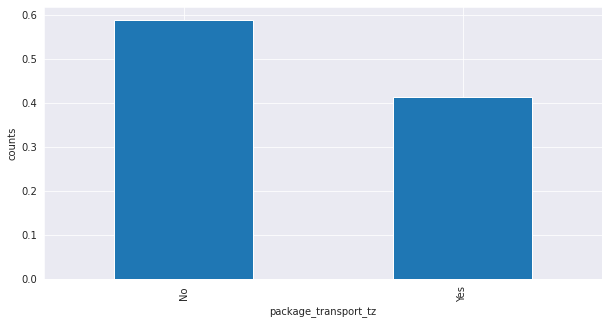

In [ ]:

print(train['package_transport_tz'].value_counts())
plt.figure(figsize=(10,5))
train['package_transport_tz'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('package_transport_tz')

#### Majority Tanzania transport package was not provided

### Package SightSeeing

No     12786
Yes     5720
Name: package_sightseeing, dtype: int64


Text(0.5, 0, 'package_sightseeing')

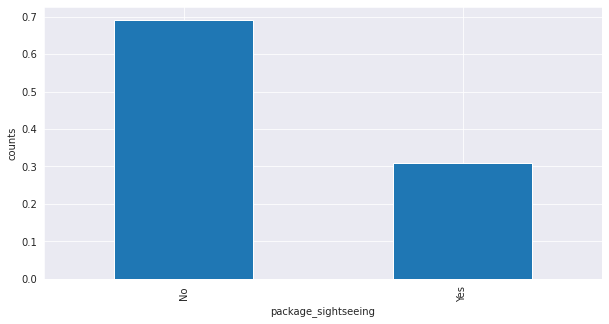

In [ ]:

print(train['package_sightseeing'].value_counts())
plt.figure(figsize=(10,5))
train['package_sightseeing'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('package_sightseeing')

#### Majority Package_sightseeing was not provided

### Package Guided Tour

No     12447
Yes     6059
Name: package_guided_tour, dtype: int64


Text(0.5, 0, 'package_guided_tour')

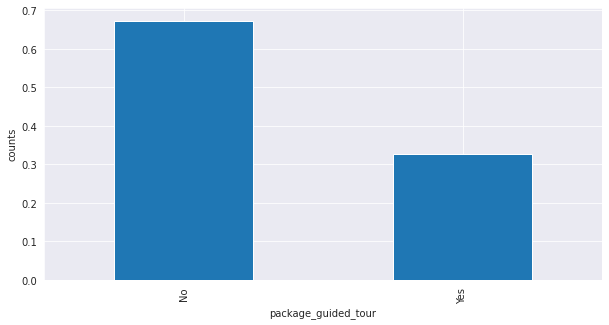

In [ ]:

print(train['package_guided_tour'].value_counts())
plt.figure(figsize=(10,5))
train['package_guided_tour'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('package_guided_tour')

#### Majority package guided tour wasnt provided

### Package Insurance

No     15809
Yes     2697
Name: package_insurance, dtype: int64


Text(0.5, 0, 'package_insurance')

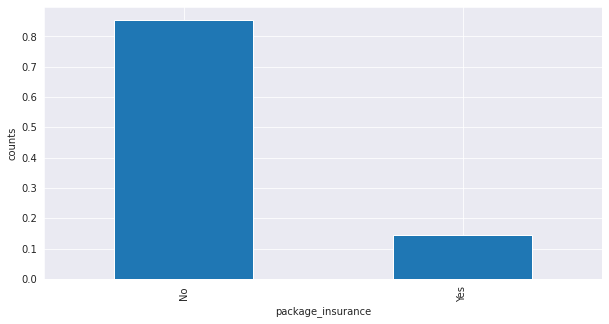

In [ ]:

print(train['package_insurance'].value_counts())
plt.figure(figsize=(10,5))
train['package_insurance'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('package_insurance')

#### Majority Package_insurance was not provided and there is an imbalance between the two classes

### First Trip Tz

Yes    12737
No      5769
Name: first_trip_tz, dtype: int64


Text(0.5, 0, 'first_trip_tz')

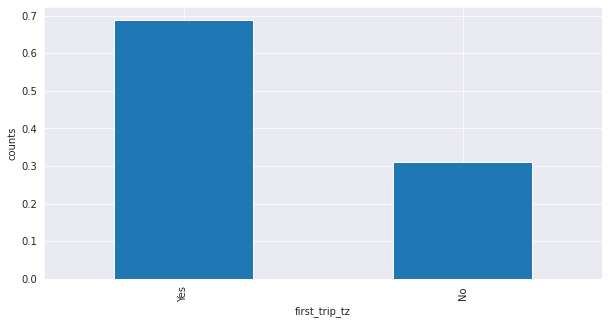

In [ ]:

print(train['first_trip_tz'].value_counts())
plt.figure(figsize=(10,5))
train['first_trip_tz'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('first_trip_tz')

#### Majority it was their first time in Tanzania

### Now lets look at the Target class and see if its imbalanced

Normal Cost     5471
Higher Cost     4865
High Cost       3678
Lower Cost      2567
Low Cost        1566
Highest Cost     359
Name: cost_category, dtype: int64


Text(0.5, 0, 'Cost_Category')

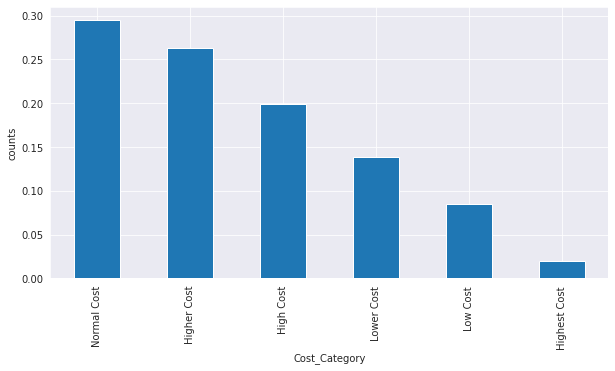

In [ ]:
print(train['cost_category'].value_counts())
plt.figure(figsize=(10,5))
train['cost_category'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('Cost_Category')

#### The last class is imbalanced so a stratified KFold would do here

## Categorical Data vs Target

Text(0.5, 1.0, 'Purpose vs CostCategory')

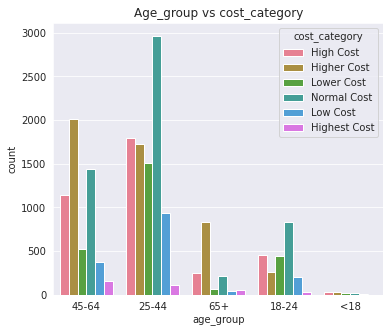

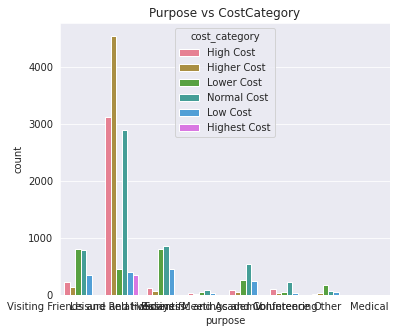

In [ ]:
#CATEGORICAL DATA
plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
sb.countplot(x='age_group',hue='cost_category',data=train,palette='husl')
plt.title("Age_group vs cost_category")

plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
sb.countplot(x='purpose',hue='cost_category',data=train,palette='husl')
plt.title("Purpose vs CostCategory")



### Conclusion Categorical Features 
* Most categorical columns have fairly distributed classes except a few classes
* All the distribution makes sense
* We can come up with new features by adding all the package columns
* No ordinal columns so we can use get_dummies or label_encoding

## Categorical Features, Feature Engineering

In [ ]:
#CONCATENATING BOTH THE TEST AND TRAIN FOR EASY DATA MANIPULATON
ntrain = train.shape[0]
ntest = test.shape[0]
data = pd.concat((train, test)).reset_index(drop=True)

In [ ]:
data.columns

Index(['Tour_ID', 'country', 'age_group', 'travel_with', 'total_female',
       'total_male', 'purpose', 'main_activity', 'info_source',
       'tour_arrangement', 'package_transport_int', 'package_accomodation',
       'package_food', 'package_transport_tz', 'package_sightseeing',
       'package_guided_tour', 'package_insurance', 'night_mainland',
       'night_zanzibar', 'first_trip_tz', 'cost_category'],
      dtype='object')

### Binning + integer encoding manually

In [ ]:
def agegroup_rename(x):
    over65 = ['65+']
    less18 = ['<18']
    youth = ['25-44']
    adult = ['45-64']
    teen = ['18-24']
    


    if x in over65:
        return 1
    elif x in less18:
        return 2
    elif x in youth:
        return 3
    elif x in adult:
        return 4    
    elif x in teen:
        return 5   
    
def travelwith_rename(x):
    alone = ['Alone']
    spouse = ['With Spouse']
    frierel = ['With Other Friends/Relatives']
    spch = ['With Spouse and Children']
    nan = ['nan']
    ch = ['With Children']
    


    if x in alone:
        return 1
    elif x in spouse:
        return 2
    elif x in frierel:
        return 3
    elif x in spch:
        return 4    
    elif x in nan:
        return 5   
    elif x in ch:
        return 6   
    

def infosource_rename(x):
    agto = ['Travel agent, tour operator']
    fr = ['Friends, relatives']
    ot = ['Others']
    nmb = ['Newspaper, magazines, brochures']
    rtw = ['Radio, TV, Web']
    tf = ['Trade fair','Tanzania Mission Abroad','Inflight magazines']

    


    if x in agto:
        return 1
    elif x in fr:
        return 2
    elif x in ot:
        return 3
    elif x in nmb:
        return 4    
    elif x in rtw:
        return 5   
    elif x in tf:
        return 6   
    elif x in tma:
        return 7   
    elif x in im:
        return 8       



def mainactivity_clusters(x):
    widlife = ['Widlife Tourism']
    wildlife = ['Wildlife Tourism']
    beach = ['Beach Tourism']
    conference = ['Conference Tourism']  
    hunting = ['Hunting Tourism']
    cultural = [ 'Cultural Tourism']
    mou = ['Mountain Climbing','Business','Bird Tourism','Diving and Sport Fishing']
    

    if x in wildlife:
        return 1
    if x in widlife:
        return 7
    elif x in beach:
        return 2
    elif x in conference:
        return 3
    elif x in hunting:
        return 4    
    elif x in cultural:
        return 5 
    elif x in mou:
        return 6 
  
    
data['main_activity'] = data['main_activity'].apply(mainactivity_clusters)
print(data['main_activity'].value_counts())


data['info_source'] = data['info_source'].apply(infosource_rename)
print(data['info_source'].value_counts())



data['travel_with'] = data['travel_with'].apply(travelwith_rename)
print(data['travel_with'].value_counts())

data['age_group'] = data['age_group'].apply(agegroup_rename)
print(data['age_group'].value_counts())




7    8035
2    5604
1    3015
3    2532
4    2235
5    1939
6    1315
Name: main_activity, dtype: int64
1    10654
2     8122
3     1800
4     1730
5     1637
6      732
Name: info_source, dtype: int64
1    10118
2     6435
3     4319
4     1639
5     1436
6      728
Name: travel_with, dtype: int64
3    12068
4     7555
5     2951
1     1947
2      154
Name: age_group, dtype: int64


## FEATURE INTERACTIONS

### Capping before Data Interaction

In [ ]:
skewed = ['total_male','total_female','night_mainland','night_zanzibar']
data[skewed].describe(percentiles=[0.05,0.95])

,total_male,total_female,night_mainland,night_zanzibar
count,24675.000000,24675.000000,24675.000000,24675.000000
mean,1.003161,0.932644,9.184113,2.516596
std,1.270623,1.205047,14.719152,5.323307
min,0.000000,0.000000,0.000000,0.000000
5%,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,6.000000,0.000000
95%,2.000000,3.000000,28.000000,10.000000
max,90.000000,49.000000,664.000000,240.000000


In [ ]:
data['total_female'].loc[data['total_female'] > 3.000000]  = 4.000000
data['total_male'].loc[data['total_male'] > 2.000000]  = 3.000000
data['night_mainland'].loc[data['night_mainland'] > 28.000000]  = 30.000000
data['night_zanzibar'].loc[data['night_zanzibar'] > 10.000000]  = 11.000000

#### Feature Interactions

In [ ]:
data['total_people'] = data['total_male']+data['total_female']
data['diff_male_female'] = data['total_female'] - data["total_male"]
data['total_nights'] = data['night_mainland'] + data['night_zanzibar']
data['diff_nights'] = data['night_mainland'] - data['night_zanzibar']







In [ ]:

data['prod_nights_people'] = data['total_nights']*data['total_people']
data['diff_nights_people'] = data['total_nights']-data['total_people']
data['sum_nights_people'] = data['total_nights']+data['total_people']


In [ ]:
is_African = []
african = ['SOUTH AFRICA', 'NIGERIA', 'RWANDA', 'MOZAMBIQUE', 'KENYA', 'ALGERIA', 'EGYPT','MALAWI', 
           'UGANDA', 'ZIMBABWE', 'ZAMBIA', 'CONGO', 'MAURITIUS', 'DRC', 'TUNISIA', 'ETHIOPIA','BURUNDI',
           'GHANA', 'NIGER', 'COMORO', 'ANGOLA', 'SUDAN', 'NAMIBIA', 'LESOTHO', 'IVORY COAST', 'MADAGASCAR',
           'DJIBOUT', 'MORROCO', 'BOTSWANA', 'LIBERIA', 'GUINEA', 'SOMALI']

for country in data['country']:
  if country in african:
    is_African.append(True)
  else:
    is_African.append(False)

data['is_african'] = is_African

In [ ]:
data['package_all'] = data['package_transport_int'].astype(str) + data['package_accomodation'].astype(str) + data['package_food'].astype(str) + data['package_transport_tz'].astype(str)+ data['package_sightseeing'].astype(str)+ data['package_insurance'].astype(str)+data['package_guided_tour'].astype(str)
data['tour_total_people'] = data['tour_arrangement'] + data['total_people'].astype('str')
data['tour_total_nights'] = data['tour_arrangement'] + data['total_nights'].astype('str')
data['tour_package_all'] = data['tour_arrangement'] + data['package_all']
data['activity_touur'] = data['tour_arrangement']+data['main_activity'].astype(str)


In [ ]:
data.columns

Index(['Tour_ID', 'country', 'age_group', 'travel_with', 'total_female',
       'total_male', 'purpose', 'main_activity', 'info_source',
       'tour_arrangement', 'package_transport_int', 'package_accomodation',
       'package_food', 'package_transport_tz', 'package_sightseeing',
       'package_guided_tour', 'package_insurance', 'night_mainland',
       'night_zanzibar', 'first_trip_tz', 'cost_category', 'total_people',
       'diff_male_female', 'total_nights', 'diff_nights', 'prod_nights_people',
       'diff_nights_people', 'sum_nights_people', 'is_african', 'package_all',
       'tour_total_people', 'tour_total_nights', 'tour_package_all',
       'activity_touur'],
      dtype='object')

### 1. Count Encoding

In [ ]:
# check unique values in dataset
data.apply(lambda x: len(x.unique()))

Tour_ID                  24675
country                    141
age_group                    5
travel_with                  6
total_female                 5
total_male                   4
purpose                      8
main_activity                7
info_source                  6
tour_arrangement             2
package_transport_int        2
package_accomodation         2
package_food                 2
package_transport_tz         2
package_sightseeing          2
package_guided_tour          2
package_insurance            2
night_mainland              30
night_zanzibar              12
first_trip_tz                2
cost_category                7
total_people                 8
diff_male_female             8
total_nights                41
diff_nights                 42
prod_nights_people         134
diff_nights_people          46
sum_nights_people           45
is_african                   2
package_all                120
tour_total_people           16
tour_total_nights           82
tour_pac

In [ ]:
cat_cols = ['country','total_male','is_african','total_female','total_people','total_nights','night_mainland','night_zanzibar'
           
           ]



## Count of unique features
for i in cat_cols:
    data['count_'+i] = data[i].map(data[i].value_counts())
# cat_cols

In [ ]:
data.head()

,Tour_ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,tour_package_all,activity_touur,count_country,count_total_male,count_is_african,count_total_female,count_total_people,count_total_nights,count_night_mainland,count_night_zanzibar
0,tour_id1hffseyw,ITALY,4,6,0.0,2.0,Visiting Friends and Relatives,2,2,Package Tour,...,Package TourYesYesYesYesNoNoNo,Package Tour2,2171,2036,19106,8230,8892,3068,3119,2043
1,tour_idnacd7zag,UNITED KINGDOM,3,2,1.0,1.0,Leisure and Holidays,1,1,Package Tour,...,Package TourYesYesYesYesNoNoNo,Package Tour1,2819,15772,19106,12854,8892,3068,3119,2043
2,tour_id62vz7e71,UNITED STATES OF AMERICA,1,2,1.0,1.0,Leisure and Holidays,7,1,Package Tour,...,Package TourYesYesYesYesYesNoYes,Package Tour7,3765,15772,19106,12854,8892,1163,1676,831
3,tour_idrc76tzix,RWANDA,3,4,3.0,1.0,Leisure and Holidays,2,5,Independent,...,IndependentNoNoNoNoNoNoNo,Independent2,192,15772,5569,690,1330,1604,1709,15431
4,tour_idn723m0n9,UNITED STATES OF AMERICA,4,1,0.0,1.0,Leisure and Holidays,7,1,Package Tour,...,Package TourYesYesYesYesNoYesYes,Package Tour7,3765,15772,19106,8230,11843,3068,2266,15431


### 2. Groupby mean Encoding and difference

#### These groups categorical colums with numercal columns means

In [ ]:
data['gb_feature_country_total_people'] = data.groupby(['country'])['total_people'].transform('mean')
data['gb_feature_age_group_total_people'] = data.groupby(['age_group'])['total_people'].transform('mean')
data['gb_feature_travel_with_total_people'] = data.groupby(['travel_with'])['total_people'].transform('mean')
data['gb_feature_purpose_total_people'] = data.groupby(['purpose'])['total_people'].transform('mean')
data['gb_feature_main_activity_total_people'] = data.groupby(['main_activity'])['total_people'].transform('mean')
data['gb_feature_tour_arrangement_total_people'] = data.groupby(['tour_arrangement'])['total_people'].transform('mean')
data['gb_feature_first_trip_tz_total_people'] = data.groupby(['first_trip_tz'])['total_people'].transform('mean')

In [ ]:
data['gb_feature_country_total_nights'] = data.groupby(['country'])['total_nights'].transform('mean')
data['gb_feature_age_group_total_nights'] = data.groupby(['age_group'])['total_nights'].transform('mean')
data['gb_feature_travel_with_total_nights'] = data.groupby(['travel_with'])['total_nights'].transform('mean')
data['gb_feature_purpose_total_nights'] = data.groupby(['purpose'])['total_nights'].transform('mean')
data['gb_feature_main_activity_total_nights'] = data.groupby(['main_activity'])['total_nights'].transform('mean')
data['gb_feature_tour_arrangement_total_nights'] = data.groupby(['tour_arrangement'])['total_nights'].transform('mean')
data['gb_feature_first_trip_tz_total_nights'] = data.groupby(['first_trip_tz'])['total_nights'].transform('mean')

In [ ]:
data['gb_feature_country_prod_nights_people'] = data.groupby(['country'])['prod_nights_people'].transform('mean')
data['gb_feature_age_group_prod_nights_people'] = data.groupby(['age_group'])['prod_nights_people'].transform('mean')
data['gb_feature_travel_with_prod_nights_people'] = data.groupby(['travel_with'])['prod_nights_people'].transform('mean')
data['gb_feature_purpose_prod_nights_people'] = data.groupby(['purpose'])['prod_nights_people'].transform('mean')
data['gb_feature_main_activity_prod_nights_people'] = data.groupby(['main_activity'])['prod_nights_people'].transform('mean')
data['gb_feature_tour_arrangement_prod_nights_people'] = data.groupby(['tour_arrangement'])['prod_nights_people'].transform('mean')
data['gb_feature_first_trip_tz_prod_nights_people'] = data.groupby(['first_trip_tz'])['prod_nights_people'].transform('mean')

In [ ]:
data['gb_feature_country_sum_nights_people'] = data.groupby(['country'])['sum_nights_people'].transform('mean')
data['gb_feature_age_group_sum_nights_people'] = data.groupby(['age_group'])['sum_nights_people'].transform('mean')
data['gb_feature_travel_with_sum_nights_people'] = data.groupby(['travel_with'])['sum_nights_people'].transform('mean')
data['gb_feature_purpose_sum_nights_people'] = data.groupby(['purpose'])['sum_nights_people'].transform('mean')
data['gb_feature_main_activity_sum_nights_people'] = data.groupby(['main_activity'])['sum_nights_people'].transform('mean')
data['gb_feature_tour_arrangement_sum_nights_people'] = data.groupby(['tour_arrangement'])['sum_nights_people'].transform('mean')
data['gb_feature_first_trip_tz_sum_nights_people'] = data.groupby(['first_trip_tz'])['sum_nights_people'].transform('mean')

In [ ]:
data['gb_feature_country_diff_nights_people'] = data.groupby(['country'])['diff_nights_people'].transform('mean')
data['gb_feature_age_group_diff_nights_people'] = data.groupby(['age_group'])['diff_nights_people'].transform('mean')
data['gb_feature_travel_with_diff_nights_people'] = data.groupby(['travel_with'])['diff_nights_people'].transform('mean')
data['gb_feature_purpose_diff_nights_people'] = data.groupby(['purpose'])['diff_nights_people'].transform('mean')
data['gb_feature_main_activity_diff_nights_people'] = data.groupby(['main_activity'])['diff_nights_people'].transform('mean')
data['gb_feature_tour_arrangement_diff_nights_people'] = data.groupby(['tour_arrangement'])['diff_nights_people'].transform('mean')
data['gb_feature_first_trip_tz_diff_nights_people'] = data.groupby(['first_trip_tz'])['diff_nights_people'].transform('mean')

In [ ]:
data['gb_feature_country_diff_nights'] = data.groupby(['country'])['diff_nights'].transform('mean')
data['gb_feature_age_group_diff_nights'] = data.groupby(['age_group'])['diff_nights'].transform('mean')
data['gb_feature_travel_with_diff_nights'] = data.groupby(['travel_with'])['diff_nights'].transform('mean')
data['gb_feature_purpose_diff_nights'] = data.groupby(['purpose'])['diff_nights'].transform('mean')
data['gb_feature_main_activity_diff_nights'] = data.groupby(['main_activity'])['diff_nights'].transform('mean')
data['gb_feature_tour_arrangement_diff_nights'] = data.groupby(['tour_arrangement'])['diff_nights'].transform('mean')
data['gb_feature_first_trip_tz_diff_nights'] = data.groupby(['first_trip_tz'])['diff_nights'].transform('mean')

In [ ]:
data['gb_feature_country_diff_male_female'] = data.groupby(['country'])['diff_male_female'].transform('mean')
data['gb_feature_age_group_diff_male_female'] = data.groupby(['age_group'])['diff_male_female'].transform('mean')
data['gb_feature_travel_with_diff_male_female'] = data.groupby(['travel_with'])['diff_male_female'].transform('mean')
data['gb_feature_purpose_diff_male_female'] = data.groupby(['purpose'])['diff_male_female'].transform('mean')
data['gb_feature_main_activity_diff_male_female'] = data.groupby(['main_activity'])['diff_male_female'].transform('mean')
data['gb_feature_tour_arrangement_diff_male_female'] = data.groupby(['tour_arrangement'])['diff_male_female'].transform('mean')
data['gb_feature_first_trip_tz_diff_male_female'] = data.groupby(['first_trip_tz'])['diff_male_female'].transform('mean')

In [ ]:
data.head()

,Tour_ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,gb_feature_main_activity_diff_nights,gb_feature_tour_arrangement_diff_nights,gb_feature_first_trip_tz_diff_nights,gb_feature_country_diff_male_female,gb_feature_age_group_diff_male_female,gb_feature_travel_with_diff_male_female,gb_feature_purpose_diff_male_female,gb_feature_main_activity_diff_male_female,gb_feature_tour_arrangement_diff_male_female,gb_feature_first_trip_tz_diff_male_female
0,tour_id1hffseyw,ITALY,4,6,0.0,2.0,Visiting Friends and Relatives,2,2,Package Tour,...,0.479657,4.513226,5.254889,0.057117,-0.083124,0.265110,-0.075300,-0.003747,0.095261,0.040705
1,tour_idnacd7zag,UNITED KINGDOM,3,2,1.0,1.0,Leisure and Holidays,1,1,Package Tour,...,6.870647,4.513226,5.254889,0.063143,-0.123053,0.009790,0.092005,-0.024876,0.095261,0.040705
2,tour_id62vz7e71,UNITED STATES OF AMERICA,1,2,1.0,1.0,Leisure and Holidays,7,1,Package Tour,...,7.417299,4.513226,5.254889,0.111554,0.076528,0.009790,0.092005,0.019415,0.095261,0.040705
3,tour_idrc76tzix,RWANDA,3,4,3.0,1.0,Leisure and Holidays,2,5,Independent,...,0.479657,7.104688,7.035199,0.125000,-0.123053,0.136669,0.092005,-0.003747,-0.203141,-0.263151
4,tour_idn723m0n9,UNITED STATES OF AMERICA,4,1,0.0,1.0,Leisure and Holidays,7,1,Package Tour,...,7.417299,4.513226,5.254889,0.111554,-0.083124,-0.245800,0.092005,0.019415,0.095261,0.040705


### 4. Pandas Get Dummies

In [ ]:
data = pd.get_dummies(data, columns = [
 'age_group','main_activity','package_transport_int','first_trip_tz',
])
data.head(3)

,Tour_ID,country,travel_with,total_female,total_male,purpose,info_source,tour_arrangement,package_accomodation,package_food,...,main_activity_2,main_activity_3,main_activity_4,main_activity_5,main_activity_6,main_activity_7,package_transport_int_No,package_transport_int_Yes,first_trip_tz_No,first_trip_tz_Yes
0,tour_id1hffseyw,ITALY,6,0.0,2.0,Visiting Friends and Relatives,2,Package Tour,Yes,Yes,...,1,0,0,0,0,0,0,1,0,1
1,tour_idnacd7zag,UNITED KINGDOM,2,1.0,1.0,Leisure and Holidays,1,Package Tour,Yes,Yes,...,0,0,0,0,0,0,0,1,0,1
2,tour_id62vz7e71,UNITED STATES OF AMERICA,2,1.0,1.0,Leisure and Holidays,1,Package Tour,Yes,Yes,...,0,0,0,0,0,1,0,1,0,1


### 5. Label Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le_columns = [col for col in data.select_dtypes('object').columns if col not in ['Tour_ID','cost_category']]

for col in le_columns:
   data[col] = le.fit_transform(data[col])

In [ ]:
data.head()

,Tour_ID,country,travel_with,total_female,total_male,purpose,info_source,tour_arrangement,package_accomodation,package_food,...,main_activity_2,main_activity_3,main_activity_4,main_activity_5,main_activity_6,main_activity_7,package_transport_int_No,package_transport_int_Yes,first_trip_tz_No,first_trip_tz_Yes
0,tour_id1hffseyw,62,6,0.0,2.0,6,2,1,1,1,...,1,0,0,0,0,0,0,1,0,1
1,tour_idnacd7zag,133,2,1.0,1.0,1,1,1,1,1,...,0,0,0,0,0,0,0,1,0,1
2,tour_id62vz7e71,134,2,1.0,1.0,1,1,1,1,1,...,0,0,0,0,0,1,0,1,0,1
3,tour_idrc76tzix,106,4,3.0,1.0,1,5,0,0,0,...,1,0,0,0,0,0,1,0,1,0
4,tour_idn723m0n9,134,1,0.0,1.0,1,1,1,1,1,...,0,0,0,0,0,1,0,1,0,1


## Continous Features
* The only continous features we had were total_female and male and nights in zanzibar or mainland and we have already explored those

###  Add statistical Information on the Numerical Columns

In [ ]:
num_cols = ['diff_male_female','total_people',
       'total_nights', 'diff_nights', 'prod_nights_people',
       'diff_nights_people', 'sum_nights_people']

In [ ]:
def add_stats(data, feats):
    
    before_ = data.shape[1]
    cols = feats
    data['f_min']   = data[cols].fillna(0).min(axis = 1)
    data['f_max']   = data[cols].fillna(0).max(axis = 1)
    data['f_mean']  = data[cols].fillna(0).mean(axis = 1)
    data['f_sd']    = data[cols].fillna(0).std(axis = 1)
    data['f_median']= data[cols].fillna(0).median(axis = 1)
    data['f_sum']   = data[cols].fillna(0).sum(axis = 1)
    data['f_skew']  = data[cols].fillna(0).skew(axis=1)

    after_ = data.shape[1]
    new_cols = data.iloc[:,before_:after_].columns.tolist()
    
    return data, new_cols

In [ ]:
data, stat_cols = add_stats(data, [col for col in num_cols])

## Separate the combined dataset

In [ ]:
# Separate train and test data from the combined dataframe
train_df = data[:ntrain]
test_df = data[ntrain:]

# Check the shapes of the split dataset
train_df.shape, test_df.shape

((18506, 110), (6169, 110))

### Label Encode the target

In [ ]:

le_columns = ['cost_category']

for col in le_columns:
   train_df[col] = le.fit_transform(train_df[col])

## Correlation

### 1. Negative correlation with the target

In [ ]:
train_df.corr()['cost_category'].sort_values()[train_df.corr()['cost_category'].sort_values() < 0]

tour_total_people                                -0.570908
tour_package_all                                 -0.558752
gb_feature_tour_arrangement_diff_male_female     -0.557917
gb_feature_tour_arrangement_prod_nights_people   -0.557917
tour_arrangement                                 -0.557917
gb_feature_tour_arrangement_total_people         -0.557917
gb_feature_tour_arrangement_sum_nights_people    -0.557917
package_accomodation                             -0.542568
package_all                                      -0.540140
package_food                                     -0.515487
activity_touur                                   -0.480628
package_transport_tz                             -0.474691
package_transport_int_Yes                        -0.452349
tour_total_nights                                -0.429959
gb_feature_purpose_total_people                  -0.425022
package_guided_tour                              -0.401703
package_sightseeing                              -0.3791

### 2. Positive correlation with the Target

In [ ]:
train_df.corr()['cost_category'].sort_values()[train_df.corr()['cost_category'].sort_values() > 0]

count_total_male                                  0.003337
night_mainland                                    0.010903
gb_feature_country_diff_nights                    0.043737
gb_feature_age_group_sum_nights_people            0.060427
gb_feature_age_group_total_nights                 0.072771
main_activity_6                                   0.079015
gb_feature_age_group_diff_nights_people           0.083828
country                                           0.087799
diff_nights                                       0.091146
age_group_5                                       0.091153
f_min                                             0.107908
main_activity_5                                   0.109450
age_group_3                                       0.119182
main_activity_4                                   0.193338
info_source                                       0.202658
count_night_zanzibar                              0.204137
purpose                                           0.2145

## Feature Selection

In [ ]:
# Select main columns to be used in training
main_cols = train_df.columns.difference(['Tour_ID','cost_category',
 'package_accomodation','tour_arrangement','travel_with',
 'package_food'])
X = train_df[main_cols]
y = train_df.cost_category

model = catt.CatBoostClassifier(random_state = 42,)

import random
random.seed(123)

train_features, valid_features, train_y, valid_y = train_test_split(X, y, test_size = 0.18, stratify = y,random_state = 47)
model.fit(train_features, train_y,eval_set = [(train_features, train_y),(valid_features,valid_y)], early_stopping_rounds = 500, 
          verbose = 200)

Learning rate set to 0.114012
0:	learn: 1.6552272	test: 1.6552272	test1: 1.6555103	best: 1.6555103 (0)	total: 121ms	remaining: 2m
200:	learn: 0.9254431	test: 0.9254431	test1: 1.0502488	best: 1.0498688 (195)	total: 11.2s	remaining: 44.6s
400:	learn: 0.8264487	test: 0.8264487	test1: 1.0509589	best: 1.0493425 (249)	total: 22s	remaining: 32.8s
600:	learn: 0.7442860	test: 0.7442860	test1: 1.0613182	best: 1.0493425 (249)	total: 33s	remaining: 21.9s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 1.049342491
bestIteration = 249

Shrink model to first 250 iterations.


## Visualize the Feature Importance

In [ ]:
pd.options.display.max_rows = 2200
#define a function to create variable importance dataframe
def get_catt_varimp(model, train_columns, max_vars=350):
    
    # Scikit-learn API LGBMClassifier or LGBMRegressor was fitted, 
    # so using feature_importances_ property
    feature_importances_perc = (model.feature_importances_ / sum(model.feature_importances_)) * 100
    cv_varimp_df = pd.DataFrame([train_columns, feature_importances_perc]).T

    cv_varimp_df.columns = ['feature_name', 'varimp (%)']

    cv_varimp_df.sort_values(by='varimp (%)', ascending=False, inplace=True)

    cv_varimp_df = cv_varimp_df.iloc[0:max_vars]   

    return cv_varimp_df
#
get_catt_varimp(model, X.columns)

,feature_name,varimp (%)
23,f_skew,5.283351
87,package_all,5.251165
63,gb_feature_tour_arrangement_diff_nights,4.955601
102,tour_total_nights,4.055616
22,f_sd,2.880189
35,gb_feature_country_diff_nights,2.85285
103,tour_total_people,2.77068
37,gb_feature_country_prod_nights_people,2.683673
6,count_country,2.651634
40,gb_feature_country_total_people,2.337268


### SELECT ONLY THOSE WITH IMPORTANCE > 0

In [ ]:
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X.columns

In [ ]:
feature_importance_df.sort_values(by='importance', ascending=False, inplace=True)
feat = feature_importance_df[feature_importance_df['importance']>0]

In [ ]:
important = feat['feature'].values
X =X[important]
X.shape

(18506, 100)

### REDUCE THE FEATURES WITH MORE THAN 0.9 CORRELATION

In [ ]:
corr = X.corr()
# sns.heatmap(corr)
#
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = X.columns[columns]
X = X[selected_columns]

### NEW TRAIN AND TEST FROM THE SELECTED_COLUMNS

In [ ]:
train = train_df[selected_columns]
test = test_df[selected_columns]
train.shape,test.shape

((18506, 63), (6169, 63))

In [ ]:
train['Tour_ID'] = train_df['Tour_ID']
test['Tour_ID'] = test_df['Tour_ID']
train['cost_category'] = train_df['cost_category']

In [ ]:
train.to_csv(path+ 'winning_train.csv',index=False)
test.to_csv(path + 'winning_test.csv',index=False)
train.shape,test.shape

((18506, 65), (6169, 64))

### MODELLING

In [ ]:
train_df = pd.read_csv(path + "winning_train.csv")
test_df = pd.read_csv(path + "winning_test.csv")
sample_submission = pd.read_csv(path+ "SampleSubmission.csv")
train_df.shape,test_df.shape

((18506, 65), (6169, 64))

In [ ]:
X = train.drop(columns=['Tour_ID','cost_category'])
y = train['cost_category']
X_test = test_df.drop(columns=['Tour_ID'])
X.shape,X_test.shape

((18506, 63), (6169, 63))

In [ ]:
fold_pred=[]
oof_pred = []

params =     params = {
        'iterations':10000,
        'random_state':42,
        'bootstrap_type':'Bernoulli',
        'max_depth': 7,
        'learning_rate': 0.008436034013684798,
        'l2_leaf_reg': 0.8908564261285311,

        
   
        
         }
 




fold= StratifiedKFold(n_splits=10)#15#5#10
i=1
for train_index, test_index in fold.split(X,y):     
  
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


    model = catt.CatBoostClassifier(**params)

    model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=250, verbose = False)#erly100

    preds= model.predict_proba(X_test)
    print("err: ",(log_loss(y_test,preds)))  
    oof_pred.append(log_loss(y_test,preds))
    p2 = model.predict_proba(test_df[X.columns])
    fold_pred.append(p2)
    

print(np.mean(oof_pred))

err:  1.028286098813759
err:  1.0498150680574345
err:  1.0532040088178174
err:  1.0608870128220773
err:  1.0927631557067121
err:  1.032852787517459
err:  1.0397215835994715
err:  1.0539089717867307
err:  1.0388964267470575
err:  1.0740166760633358
1.0524351789931854


Text(0.5, 1.0, 'CatBoostClassifier features importance (top 50):')

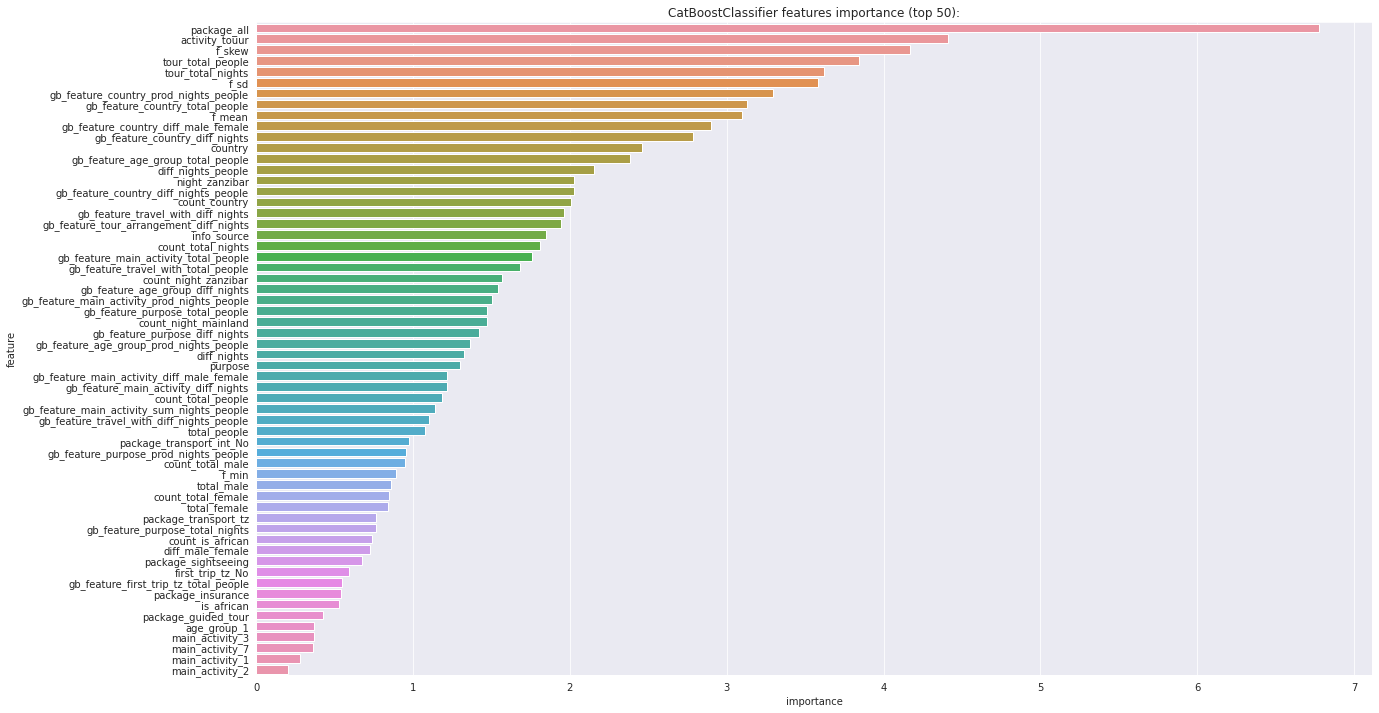

In [ ]:
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X.columns

plt.figure(figsize=(20, 12));
sb.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(60))
plt.title('CatBoostClassifier features importance (top 50):')

In [ ]:
preds = np.mean(fold_pred,axis=0)
preds_df = pd.DataFrame(preds, columns=['High Cost','Higher Cost','Highest Cost','Low Cost','Lower Cost','Normal Cost'])
preds_df = pd.concat(objs=[test_df['Tour_ID'], preds_df], axis="columns")
preds_df.head()

,Tour_ID,High Cost,Higher Cost,Highest Cost,Low Cost,Lower Cost,Normal Cost
0,tour_idynufedne,0.123826,0.029802,0.000466,0.068726,0.030991,0.746190
1,tour_id9r3y5moe,0.274492,0.518013,0.020294,0.008735,0.019701,0.158766
2,tour_idf6itml6g,0.671054,0.166856,0.003703,0.008265,0.003971,0.146151
3,tour_id99u4znru,0.027442,0.014902,0.000224,0.277484,0.142620,0.537327
4,tour_idj4i9urbx,0.017081,0.008004,0.000131,0.274360,0.304999,0.395425


In [ ]:
preds_df.to_csv(path + 'winning_sub.csv', index=False)